In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from matplotlib.markers import MarkerStyle
import seaborn as sn

from IPython.core.display import display, HTML


In [2]:
os.environ['MRIQC_DATA_FOLDER'] = str(Path.home() / 'workspace' / 'mriqc' / 'mriqc' / 'data' / 'csv')

In [3]:
CSV_HOME = Path(os.getenv('MRIQC_DATA_FOLDER', str(Path())))

In [4]:
x_abide = pd.read_csv(str(CSV_HOME / 'x_abide.csv'), index_col='subject_id')
y_abide = pd.read_csv(str(CSV_HOME / 'y_abide.csv'), index_col='subject_id')

# Drop extra rows in Y that failed to get IQMs
y_abide = y_abide[y_abide.index.isin(x_abide.index)]

sites = list(sorted(set(y_abide.site.values)))

In [5]:
# Split datasets by raters
y_abide_rater_1 = y_abide[~y_abide.rater_1.isnull()]
y_abide_rater_2 = y_abide[~y_abide.rater_2.isnull()]

# Split the overlapped participants in two, randomly.
np.random.seed(1234)
overlap = set(y_abide_rater_1.index.ravel().tolist()).intersection(y_abide_rater_2.index.ravel().tolist())
overlap_1 = np.random.choice(list(overlap), 50, replace=False).tolist()
overlap_2 = list(overlap - set(overlap_1))

# Generate the rater partition of participant ids
part_rater_1 = list(sorted(set(y_abide_rater_1.index.ravel().tolist()) - set(overlap_2)))
part_rater_2 = list(sorted(set(y_abide_rater_2.index.ravel().tolist()) - set(overlap_1)))
assert(len(set(part_rater_1).intersection(part_rater_2)) == 0)

y_rater_1 = y_abide_rater_1.loc[part_rater_1]
# y_rater_1[['site', 'rater_1']].to_csv(str(CSV_HOME / 'y_abide_rater_1.csv'))

y_rater_2 = y_abide_rater_2.loc[part_rater_2]
# y_rater_2[['site', 'rater_2']].to_csv(str(CSV_HOME / 'y_abide_rater_2.csv'))

x_rater_1 = x_abide.loc[part_rater_1]
# x_rater_1.to_csv(str(CSV_HOME / 'x_abide_rater_1.csv'))
x_rater_2 = x_abide.loc[part_rater_2]
# x_rater_2.to_csv(str(CSV_HOME / 'x_abide_rater_2.csv'))


In [33]:
y_pred_1 = pd.read_csv(str(Path.home() / 'tmp' / 'mriqc2' / 'mclf_run-20180601-080529_data-unseen_pred.csv'),
                       index_col='subject_id')

In [34]:
y_true_2 = y_rater_2.loc[y_pred_1.index].rater_2.astype(int)
# y_true_2[y_true_2 > 0] = 0
# y_true_2[y_true_2 < 0] = 1
y_pred_1.pred_y *= -2
y_pred_1.pred_y += 1
y_pred_1['y_true_2'] = y_true_2

In [52]:
full_report = '<h2>Doubtfull cases (predicted "bad")</h2>\n'

html = []
for sub in y_pred_1[(y_pred_1.pred_y == -1) & (y_pred_1.y_true_2 == 0)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))
    
full_report += ', '.join(html)

full_report += '\n<h2>Doubtfull cases (predicted "good")</h2>\n'

html = []
for sub in y_pred_1[(y_pred_1.pred_y == 1) & (y_pred_1.y_true_2 == 0)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))
full_report += ', '.join(html)

full_report += '\n<h2>Bad cases (predicted "good")</h2>\n'
    
html = []
for sub in y_pred_1[(y_pred_1.pred_y == 1) & (y_pred_1.y_true_2 == -1)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))

full_report += ', '.join(html)

full_report += '\n<h2>Good cases (predicted "bad")</h2>\n'

html = []
for sub in y_pred_1[(y_pred_1.pred_y == -1) & (y_pred_1.y_true_2 == 1)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))

full_report += ', '.join(html)
    
display(HTML(full_report))

In [65]:
y_abide_r2 = pd.read_csv(str(CSV_HOME / 'y_abide_rater_2.csv'), index_col='subject_id')
r2b_rates = y_abide_r2.rater_2.ravel()
r3_rates =  y_abide_r2[~y_abide_r2.rater_3.isnull()].rater_3.ravel()
r2b_rates[~y_abide_r2.rater_3.isnull()] = r3_rates
y_abide_r2['rater_23'] = r2b_rates
y_abide_r2.to_csv(str(CSV_HOME / 'y_abide_rater_2.csv'))

In [66]:
y_pred_2 = pd.read_csv(str(Path.home() / 'tmp' / 'mriqc2' / 'mclf_run-20180604-072408_data-unseen_pred.csv'),
                       index_col='subject_id')

y_true_1 = y_rater_1.loc[y_pred_2.index].rater_1.astype(int)
y_pred_2.pred_y *= -2
y_pred_2.pred_y += 1
y_pred_2['y_true_1'] = y_true_1

full_report = '<h2>Doubtfull cases (predicted "bad")</h2>\n'

html = []
for sub in y_pred_2[(y_pred_2.pred_y == -1) & (y_pred_2.y_true_1 == 0)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))
    
full_report += ', '.join(html)

full_report += '\n<h2>Doubtfull cases (predicted "good")</h2>\n'

html = []
for sub in y_pred_2[(y_pred_2.pred_y == 1) & (y_pred_2.y_true_1 == 0)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))
full_report += ', '.join(html)

full_report += '\n<h2>Bad cases (predicted "good")</h2>\n'
    
html = []
for sub in y_pred_2[(y_pred_2.pred_y == 1) & (y_pred_2.y_true_1 == -1)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))

full_report += ', '.join(html)

full_report += '\n<h2>Good cases (predicted "bad")</h2>\n'

html = []
for sub in y_pred_2[(y_pred_2.pred_y == -1) & (y_pred_2.y_true_1 == 1)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))

full_report += ', '.join(html)
    
display(HTML(full_report))

In [92]:
y_abide_r1 = pd.read_csv(str(CSV_HOME / 'y_abide_rater_1.csv'), index_col='subject_id')
r1b_rates = y_abide_r1.rater_1.ravel()
r3_rates =  y_abide_r1[~y_abide_r1.rater_3.isnull()].rater_3.ravel()
r1b_rates[~y_abide_r1.rater_3.isnull()] = r3_rates
y_abide_r1['rater_13'] = r1b_rates
y_abide_r1.to_csv(str(CSV_HOME / 'y_abide_rater_1.csv'))

In [93]:
y_abide_r1 = y_abide_r1[['site', 'rater_13']]
y_abide_r1.columns = ['site', 'rater_23']
new_abide = pd.concat((y_abide_r1[['site', 'rater_23']], y_abide_r2[['site', 'rater_23']]))
new_abide.columns = ['site', 'rater_3']
new_abide = new_abide.sort_index()
new_abide.to_csv(str(CSV_HOME / 'y_abide_rater_3.csv'))

In [8]:
y_pred_ds30 = pd.read_csv(str(Path.home() / 'tmp' / 'mriqc2' / 'mclf_run-20180606-080637_data-test_pred.csv'),
                       index_col='subject_id')
y_ds30 = pd.read_csv(str(CSV_HOME / 'y_ds030.csv'), index_col='subject_id')

# Drop extra rows in Y that failed to get IQMs
y_ds30 = y_ds30[y_ds30.index.isin(y_ds30.index)]

full_report = '<h2>Doubtfull cases (predicted "bad")</h2>\n'

html = []
for sub in y_pred_ds30[(y_pred_ds30.pred_y == 1) & (y_ds30.rater_1 == 0)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))
    
full_report += ', '.join(html)

full_report += '\n<h2>Doubtfull cases (predicted "good")</h2>\n'

html = []
for sub in y_pred_ds30[(y_pred_ds30.pred_y == 0) & (y_ds30.rater_1 == 0)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))
full_report += ', '.join(html)

full_report += '\n<h2>Bad cases (predicted "good")</h2>\n'
    
html = []
for sub in y_pred_ds30[(y_pred_ds30.pred_y == 0) & (y_ds30.rater_1 == -1)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))

full_report += ', '.join(html)

full_report += '\n<h2>Good cases (predicted "bad")</h2>\n'

html = []
for sub in y_pred_ds30[(y_pred_ds30.pred_y == 1) & (y_ds30.rater_1 == 1)].index.ravel():
    html.append('<a target="_blank" href="http://localhost:8000/sub-{0}_T1w.html">{0}</a>'.format(sub))

full_report += ', '.join(html)
    
display(HTML(full_report))

In [41]:
x_abide = pd.read_csv(str(CSV_HOME / 'x_abide.csv'), index_col='subject_id')
y_abide = pd.read_csv(str(CSV_HOME / 'y_abide.csv'), index_col='subject_id')

# Drop extra rows in Y that failed to get IQMs
y_abide = y_abide[y_abide.index.isin(x_abide.index)]

sites = list(sorted(set(y_abide.site.values)))

y_abide_r1 = pd.read_csv(str(CSV_HOME / 'y_abide_rater_1.csv'), index_col='subject_id')
y_abide_r2 = pd.read_csv(str(CSV_HOME / 'y_abide_rater_2.csv'), index_col='subject_id')

y_abide.rater_3 = [np.nan] * len(y_abide)
y_abide.loc[y_abide_r1[~y_abide_r1.rater_3.isnull()].index, 'rater_3'] = y_abide_r1[~y_abide_r1.rater_3.isnull()].rater_3
y_abide.loc[y_abide_r2[~y_abide_r2.rater_3.isnull()].index, 'rater_3'] = y_abide_r2[~y_abide_r2.rater_3.isnull()].rater_3


y_abide['rater_123'] = [np.nan] * len(y_abide)
y_abide.loc[y_abide[~y_abide.rater_1.isnull()].index, 'rater_123'] = y_abide[~y_abide.rater_1.isnull()].rater_1
y_abide.loc[y_abide[~y_abide.rater_2.isnull()].index, 'rater_123'] = y_abide[~y_abide.rater_2.isnull()].rater_2
y_abide.loc[y_abide[~y_abide.rater_3.isnull()].index, 'rater_123'] = y_abide[~y_abide.rater_3.isnull()].rater_3

# print(y_abide[((y_abide.rater_1 == 0) | (y_abide.rater_2 == 0)) & y_abide.rater_3.isnull()])
y_abide.loc[y_abide[y_abide.rater_123 == 0].index, 'rater_123'] = y_abide[y_abide.rater_123 == 0].rater_1
y_abide.loc[y_abide[y_abide.rater_123 == 0].index, 'rater_123'] = np.nan
y_abide[['site', 'rater_1', 'rater_2', 'rater_3', 'rater_123']].to_csv(str(CSV_HOME / 'y_abide.csv'), na_rep='', float_format='%g')

In [46]:
print(np.sum(~y_abide.rater_3.isnull()))
print(1 - np.sum(y_abide.rater_3 == -1) / np.sum(~y_abide.rater_3.isnull()))

362
0.237569060773


In [47]:
y_ds030 = pd.read_csv(str(CSV_HOME / 'y_ds030.csv'), index_col='subject_id')
r1b_rates = y_ds030.rater_1.ravel()
r1b_rates[~y_ds030.rater_3.isnull()] = y_ds030[~y_ds030.rater_3.isnull()].rater_3.ravel()
y_ds030['rater_13'] = r1b_rates
y_ds030[['site', 'rater_1', 'rater_3', 'rater_13']].to_csv(str(CSV_HOME / 'y_ds030.csv'), na_rep='n/a', float_format='%g')

In [48]:
print(np.sum(~y_ds030.rater_3.isnull()))
print(1 - np.sum(y_ds030.rater_3 == -1) / np.sum(~y_ds030.rater_3.isnull()))

155
0.81935483871


In [5]:
colors = sn.color_palette("Set2", len(sites))
markers = list(MarkerStyle.markers.keys())[:len(sites)]
cmap = {
    '-1.0': 'tomato',
    '0.0': 'gold',
    '1.0': 'limegreen',
    'nan': 'darkgray'
}

In [6]:
tsne = TSNE(n_components=2, init='random', n_iter=5000, random_state=0)
Y = tsne.fit_transform(x_abide.values)

In [7]:
from statsmodels.robust.scale import mad


# Names of features that can be normalized
coi = [
    'cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z',
    'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm',
    'summary_csf_mad', 'summary_csf_mean', 'summary_csf_median', 'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv', 'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean', 'summary_gm_median', 'summary_gm_p05', 'summary_gm_p95', 'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean', 'summary_wm_median', 'summary_wm_p05', 'summary_wm_p95', 'summary_wm_stdv'
]

x_abide_std = x_abide.copy()
for s in sites:
    site_idx = y_abide.site.str.contains(s)
    data = x_abide_std._get_numeric_data()
    site_mean = x_abide_std.loc[site_idx, coi].mean(0)
    site_sigma = mad(x_abide_std.loc[site_idx, coi].values, axis=0)
    x_abide_std.loc[site_idx, coi] -= site_mean
    x_abide_std.loc[site_idx, coi] /= site_sigma

Y_std = TSNE(n_components=2, init='random', n_iter=5000, random_state=0).fit_transform(x_abide_std.values)

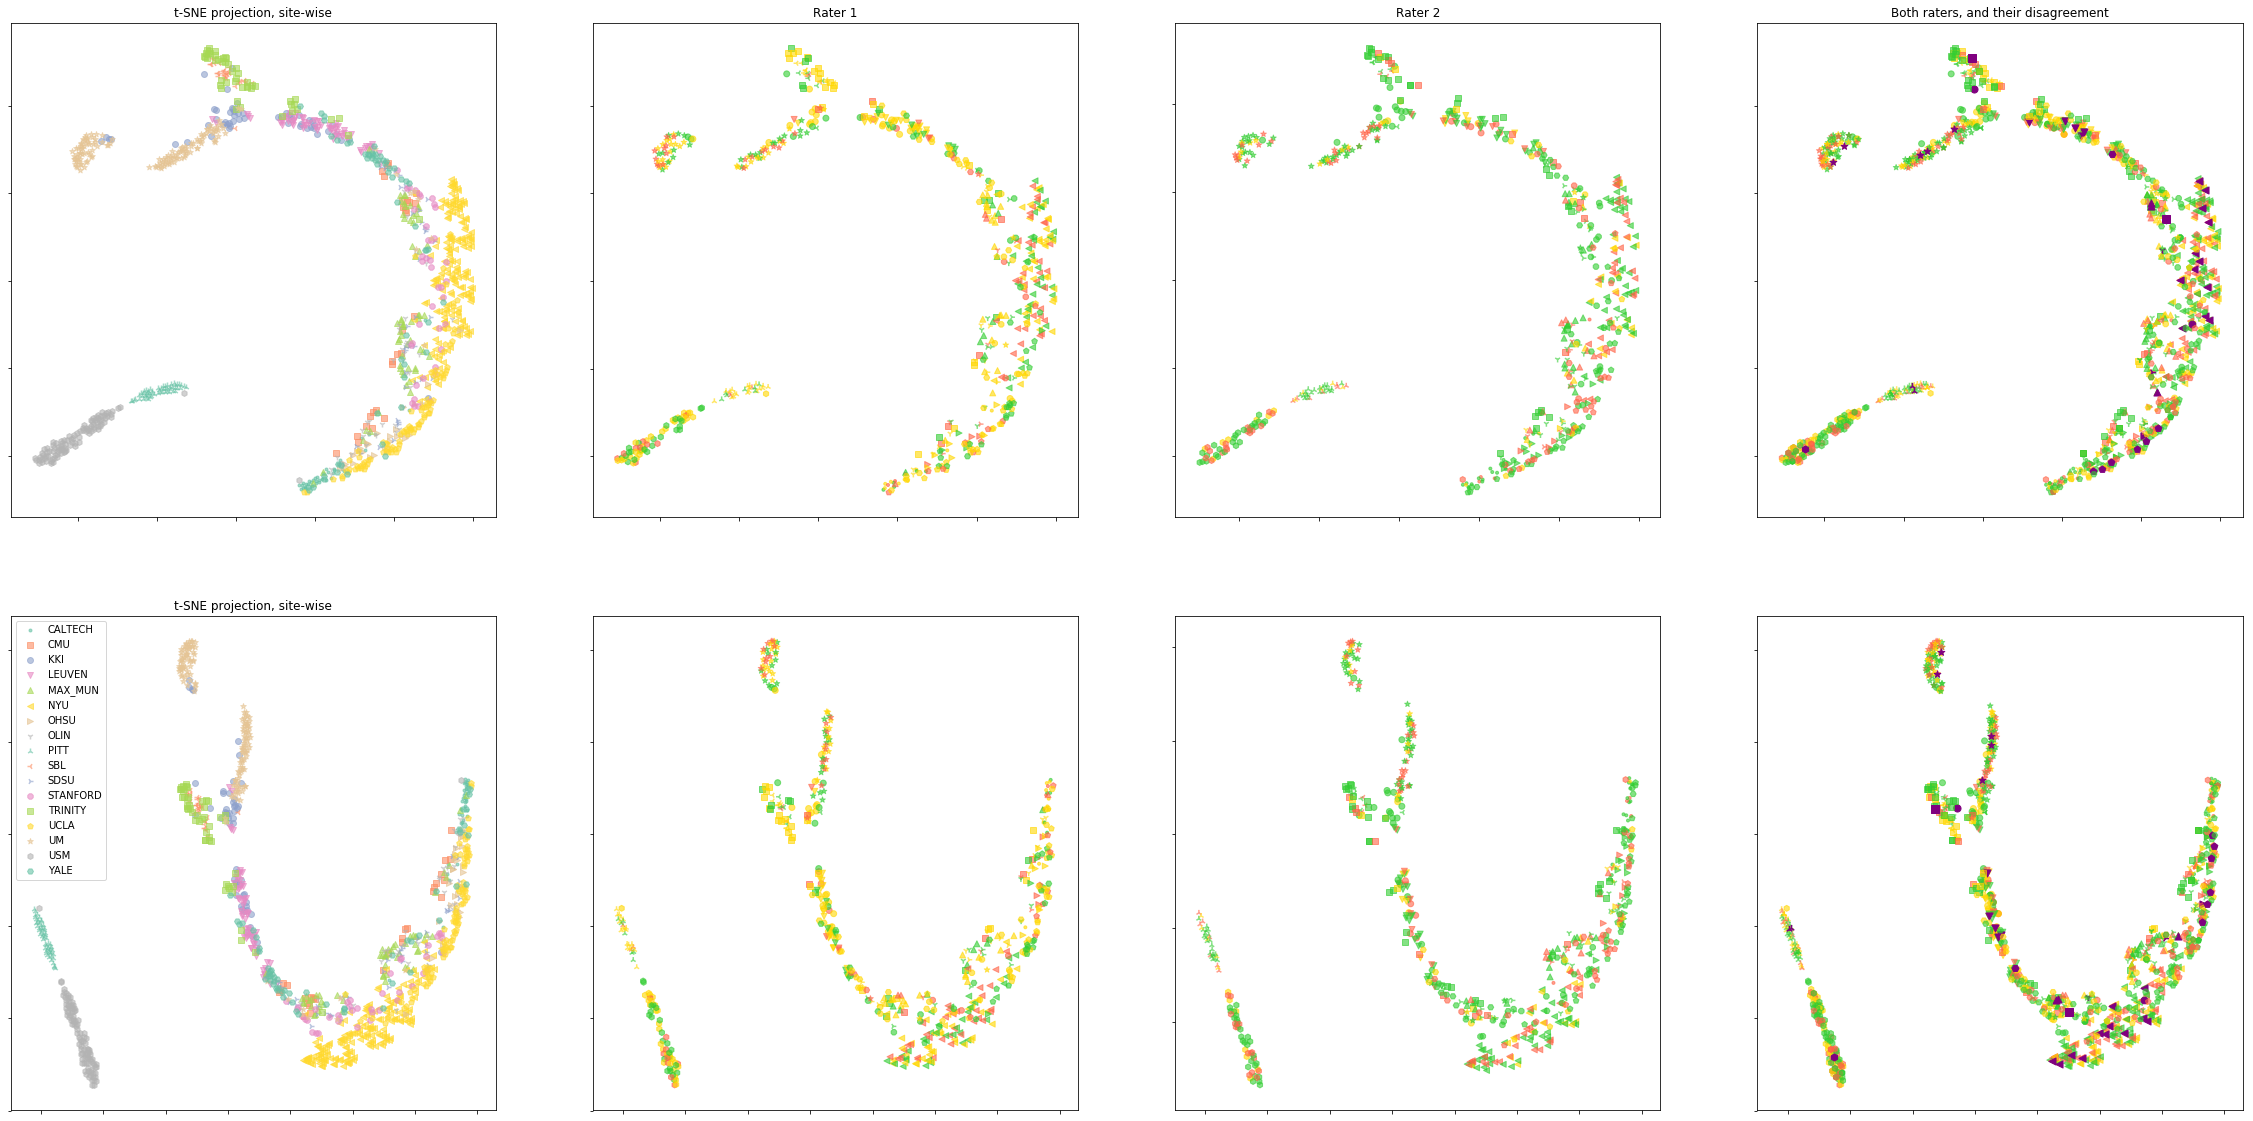

In [8]:
fig = plt.gcf()
fig.set_size_inches(40, 20)

## Plot general t-SNE
plt.subplot(2, 4, 1)
legends = []
for s, c, m in zip(sites, colors, markers):
    legends.append(
        plt.scatter(Y[y_abide.site == s, 0], Y[y_abide.site == s, 1], c=c, marker=m, alpha=.6)
    )

plt.title("t-SNE projection, site-wise")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())

## Plot rater 1
plt.subplot(2, 4, 2)
y_rater1 = y_abide[~y_abide.rater_1.isnull()]
Y_r1 = Y[~y_abide.rater_1.isnull(), :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values])
legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)

plt.title("Rater 1")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())

## Plot rater 2
plt.subplot(2, 4, 3)

y_rater2 = y_abide[~y_abide.rater_2.isnull()]
Y_r2 = Y[~y_abide.rater_2.isnull(), :]

# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values])

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    
plt.title("Rater 2")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())


## Plot agreement
plt.subplot(2, 4, 4)
y_agree = y_abide[y_abide.rater_1 == y_abide.rater_2]
Y_a = Y[y_abide.rater_1 == y_abide.rater_2, :]

idx_dis = (y_abide.rater_1 != y_abide.rater_2) & (~y_abide.rater_1.isnull() & ~y_abide.rater_2.isnull())
y_disagree = y_abide[idx_dis]
Y_b = Y[idx_dis, :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values], alpha=.6)
# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values], alpha=.6)
# plt.scatter(Y_a[:, 0], Y_a[:, 1], c=[cmap[str(v)] for v in y_agree.rater_2.values], alpha=.6)
# plt.scatter(Y_b[:, 0], Y_b[:, 1], c='darkgray')

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_a[y_agree.site == s, 0], Y_a[y_agree.site == s, 1],
                c=[cmap[str(v)] for v in y_agree.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_b[y_disagree.site == s, 0], Y_b[y_disagree.site == s, 1], marker=m, c='purple', s=50)
    
    

plt.title("Both raters, and their disagreement")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())




## Plot general t-SNE
plt.subplot(2, 4, 5)
legends = []
for s, c, m in zip(sites, colors, markers):
    legends.append(
        plt.scatter(Y_std[y_abide.site == s, 0], Y_std[y_abide.site == s, 1], c=c, marker=m, alpha=.6)
    )

plt.title("t-SNE projection, site-wise")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())
plt.legend(legends, sites)

## Plot rater 1
plt.subplot(2, 4, 6)
y_rater1 = y_abide[~y_abide.rater_1.isnull()]
Y_r1 = Y_std[~y_abide.rater_1.isnull(), :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values])
legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)

plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())

## Plot rater 2
plt.subplot(2, 4, 7)

y_rater2 = y_abide[~y_abide.rater_2.isnull()]
Y_r2 = Y_std[~y_abide.rater_2.isnull(), :]

# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values])

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())


## Plot agreement
plt.subplot(2, 4, 8)
y_agree = y_abide[y_abide.rater_1 == y_abide.rater_2]
Y_a = Y_std[y_abide.rater_1 == y_abide.rater_2, :]

idx_dis = (y_abide.rater_1 != y_abide.rater_2) & (~y_abide.rater_1.isnull() & ~y_abide.rater_2.isnull())
y_disagree = y_abide[idx_dis]
Y_b = Y_std[idx_dis, :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values], alpha=.6)
# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values], alpha=.6)
# plt.scatter(Y_a[:, 0], Y_a[:, 1], c=[cmap[str(v)] for v in y_agree.rater_2.values], alpha=.6)
# plt.scatter(Y_b[:, 0], Y_b[:, 1], c='darkgray')

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_a[y_agree.site == s, 0], Y_a[y_agree.site == s, 1],
                c=[cmap[str(v)] for v in y_agree.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_b[y_disagree.site == s, 0], Y_b[y_disagree.site == s, 1], marker=m, c='purple', s=50)
    
    plt.gca().xaxis.set_major_formatter(NullFormatter())
    plt.gca().yaxis.set_major_formatter(NullFormatter())

plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())


plt.savefig('MRIQC-abide-tsne.pdf', dpi=300, bbox_inches='tight')

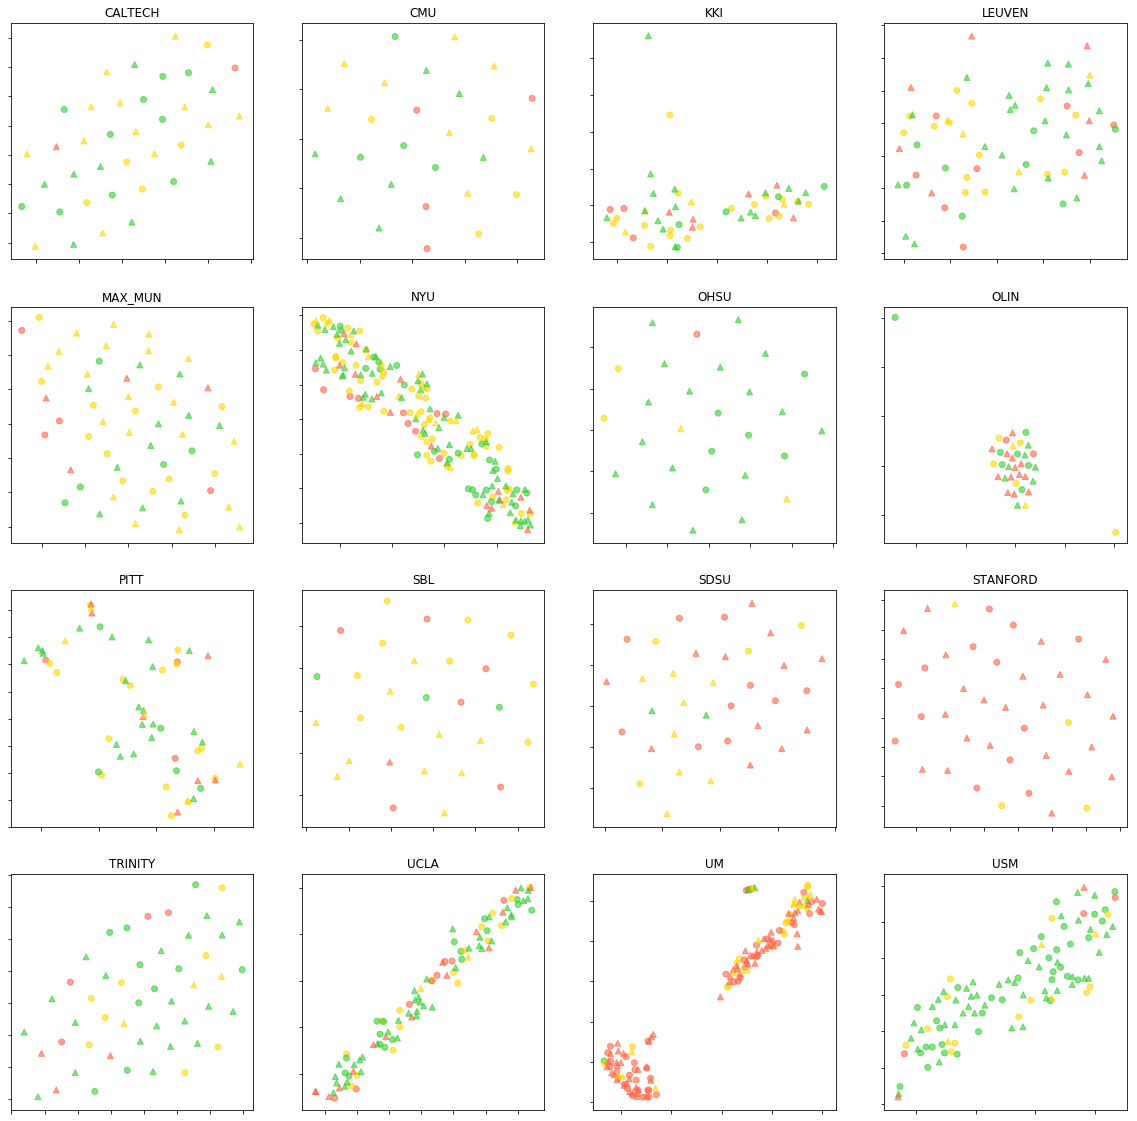

In [9]:
fig = plt.gcf()
fig.set_size_inches(20, 20)

for i, s in enumerate(sorted(sites[:16])):
    tsne = TSNE(n_components=2, init='random', n_iter=5000, random_state=0)
    Y_site = tsne.fit_transform(x_abide[y_abide.site.str.contains(s)].values)
    ysite = y_abide[y_abide.site.str.contains(s)]
    
    plt.subplot(4, 4, i + 1)
    
    ysite1 = ysite.rater_2.isnull()
    plt.scatter(Y_site[ysite1, 0], Y_site[ysite1, 1],
                c=[cmap[str(v)] for v in ysite[ysite1].rater_1.values], marker='o', alpha=.6)
    
    plt.scatter(Y_site[~ysite1, 0], Y_site[~ysite1, 1],
                c=[cmap[str(v)] for v in ysite[~ysite1].rater_2.values], marker='^', alpha=.6)
    
    plt.title(s)

    plt.gca().xaxis.set_major_formatter(NullFormatter())
    plt.gca().yaxis.set_major_formatter(NullFormatter())
    
plt.savefig('MRIQC-abide-tsne-sites.pdf', dpi=300, bbox_inches='tight')

In [20]:
from sklearn.externals.joblib import load as loadpkl
estimator = loadpkl(CSV_HOME / '..' / 'mclf_run-20170724-191452_mod-rfc_ver-0.9.7-rc8_class-2_cv-loso_data-train_estimator.pklz')

/home/oesteban/.anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.dev0 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/oesteban/.anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.dev0 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/oesteban/.anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.dev0 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/oesteban/.anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.dev0 when using version 0.19.0. This might

/home/oesteban/.anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.dev0 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/oesteban/.anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.dev0 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/oesteban/.anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.dev0 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/oesteban/.anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.de

In [22]:
keep = np.array(estimator.named_steps['sel_cols'].columns)[estimator.named_steps['ft_sites'].mask_]
discard = np.array(estimator.named_steps['sel_cols'].columns)[~estimator.named_steps['ft_sites'].mask_]

print(len(discard))
print('keep: %s' % ','.join(keep))
print('discard: %s' % ','.join(discard))

16
keep: cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,qi_1,qi_2,rpve_csf,rpve_gm,rpve_wm,snr_csf,snr_gm,snr_total,snr_wm,snrd_csf,snrd_gm,snrd_total,snrd_wm,summary_bg_k,summary_bg_stdv,summary_csf_k,summary_csf_mad,summary_csf_mean,summary_csf_median,summary_csf_p05,summary_csf_p95,summary_csf_stdv,summary_gm_k,summary_gm_mad,summary_gm_mean,summary_gm_median,summary_gm_p05,summary_gm_p95,summary_gm_stdv,summary_wm_k,summary_wm_mad,summary_wm_mean,summary_wm_median,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm
discard: icvs_wm,inu_med,inu_range,size_y,spacing_y,summary_bg_mad,summary_bg_mean,summary_bg_median,summary_bg_n,summary_bg_p05,summary_bg_p95,summary_csf_n,summary_gm_n,summary_wm_n,wm2max,site


In [28]:
keep = np.array(estimator.named_steps['sel_cols'].columns)[estimator.named_steps['ft_sites'].mask_]
discard = np.array(estimator.named_steps['sel_cols'].columns)[~estimator.named_steps['ft_sites'].mask_]

x_abide_nosites = x_abide[keep]

tsne = TSNE(n_components=2, init='random', n_iter=5000, random_state=0)
Y = tsne.fit_transform(x_abide_nosites.values)

# Names of features that can be normalized
coi = [
    'cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z',
    'snr_csf', 'snr_gm', 'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm',
    'summary_csf_mad', 'summary_csf_mean', 'summary_csf_median', 'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv', 'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean', 'summary_gm_median', 'summary_gm_p05', 'summary_gm_p95', 'summary_gm_stdv', 'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean', 'summary_wm_median', 'summary_wm_p05', 'summary_wm_p95', 'summary_wm_stdv'
]

x_abide_nosites_std = x_abide_nosites.copy()
for s in sites:
    site_idx = y_abide.site.str.contains(s)
    data = x_abide_nosites_std._get_numeric_data()
    site_mean = x_abide_nosites_std.loc[site_idx, coi].mean(0)
    site_sigma = mad(x_abide_nosites_std.loc[site_idx, coi].values, axis=0)
    x_abide_nosites_std.loc[site_idx, coi] -= site_mean
    x_abide_nosites_std.loc[site_idx, coi] /= site_sigma

Y_std = TSNE(n_components=2, init='random', n_iter=5000, random_state=0).fit_transform(x_abide_nosites_std.values)

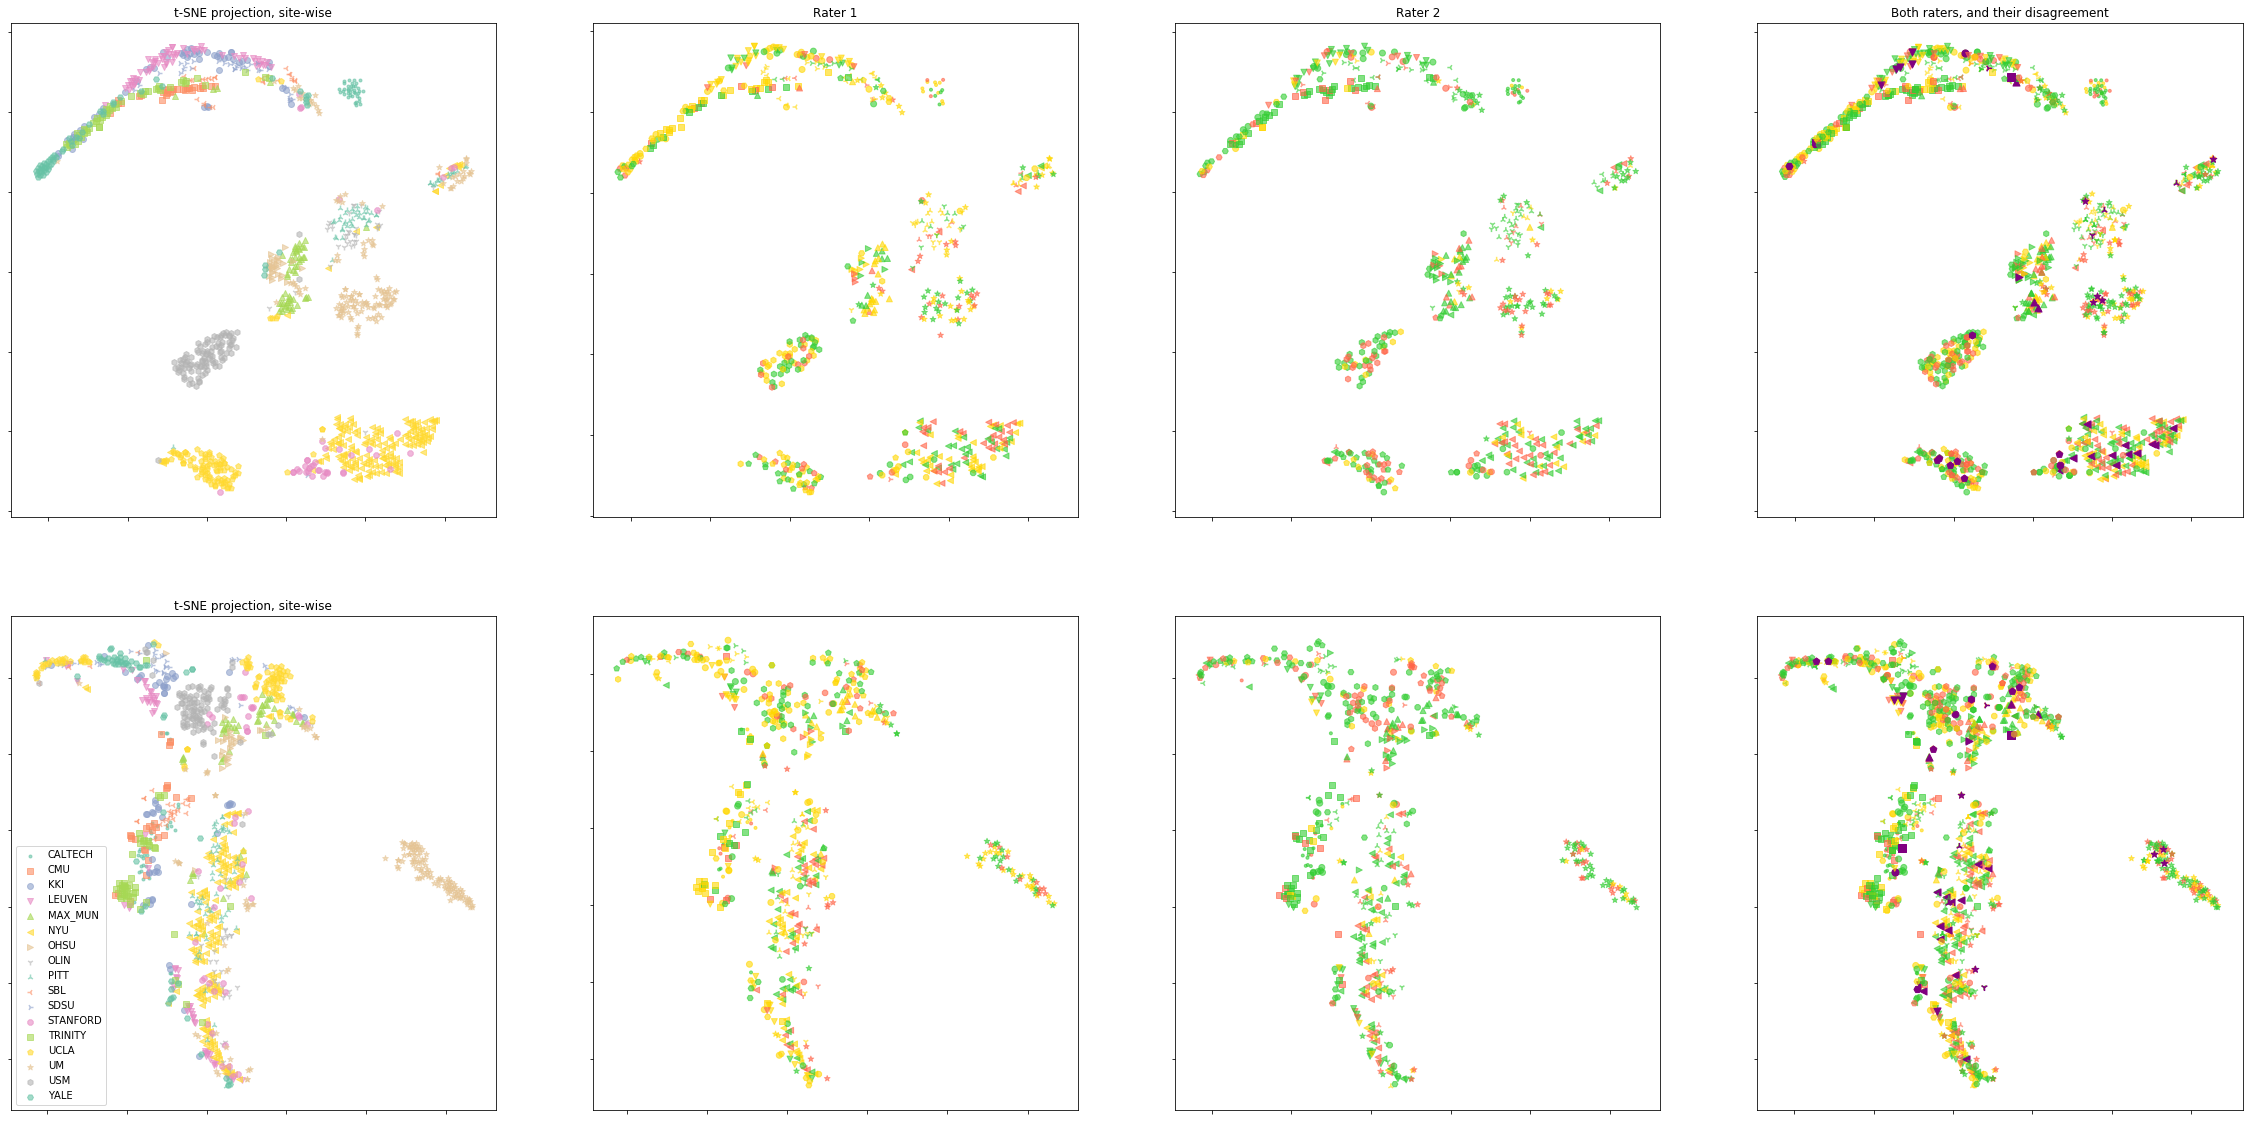

In [12]:
fig = plt.gcf()
fig.set_size_inches(40, 20)

## Plot general t-SNE
plt.subplot(2, 4, 1)
legends = []
for s, c, m in zip(sites, colors, markers):
    legends.append(
        plt.scatter(Y[y_abide.site == s, 0], Y[y_abide.site == s, 1], c=c, marker=m, alpha=.6)
    )

plt.title("t-SNE projection, site-wise")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())

## Plot rater 1
plt.subplot(2, 4, 2)
y_rater1 = y_abide[~y_abide.rater_1.isnull()]
Y_r1 = Y[~y_abide.rater_1.isnull(), :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values])
legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)

plt.title("Rater 1")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())

## Plot rater 2
plt.subplot(2, 4, 3)

y_rater2 = y_abide[~y_abide.rater_2.isnull()]
Y_r2 = Y[~y_abide.rater_2.isnull(), :]

# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values])

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    
plt.title("Rater 2")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())


## Plot agreement
plt.subplot(2, 4, 4)
y_agree = y_abide[y_abide.rater_1 == y_abide.rater_2]
Y_a = Y[y_abide.rater_1 == y_abide.rater_2, :]

idx_dis = (y_abide.rater_1 != y_abide.rater_2) & (~y_abide.rater_1.isnull() & ~y_abide.rater_2.isnull())
y_disagree = y_abide[idx_dis]
Y_b = Y[idx_dis, :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values], alpha=.6)
# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values], alpha=.6)
# plt.scatter(Y_a[:, 0], Y_a[:, 1], c=[cmap[str(v)] for v in y_agree.rater_2.values], alpha=.6)
# plt.scatter(Y_b[:, 0], Y_b[:, 1], c='darkgray')

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_a[y_agree.site == s, 0], Y_a[y_agree.site == s, 1],
                c=[cmap[str(v)] for v in y_agree.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_b[y_disagree.site == s, 0], Y_b[y_disagree.site == s, 1], marker=m, c='purple', s=50)
    
    

plt.title("Both raters, and their disagreement")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())




## Plot general t-SNE
plt.subplot(2, 4, 5)
legends = []
for s, c, m in zip(sites, colors, markers):
    legends.append(
        plt.scatter(Y_std[y_abide.site == s, 0], Y_std[y_abide.site == s, 1], c=c, marker=m, alpha=.6)
    )

plt.title("t-SNE projection, site-wise")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())
plt.legend(legends, sites)

## Plot rater 1
plt.subplot(2, 4, 6)
y_rater1 = y_abide[~y_abide.rater_1.isnull()]
Y_r1 = Y_std[~y_abide.rater_1.isnull(), :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values])
legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)

plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())

## Plot rater 2
plt.subplot(2, 4, 7)

y_rater2 = y_abide[~y_abide.rater_2.isnull()]
Y_r2 = Y_std[~y_abide.rater_2.isnull(), :]

# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values])

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())


## Plot agreement
plt.subplot(2, 4, 8)
y_agree = y_abide[y_abide.rater_1 == y_abide.rater_2]
Y_a = Y_std[y_abide.rater_1 == y_abide.rater_2, :]

idx_dis = (y_abide.rater_1 != y_abide.rater_2) & (~y_abide.rater_1.isnull() & ~y_abide.rater_2.isnull())
y_disagree = y_abide[idx_dis]
Y_b = Y_std[idx_dis, :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values], alpha=.6)
# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values], alpha=.6)
# plt.scatter(Y_a[:, 0], Y_a[:, 1], c=[cmap[str(v)] for v in y_agree.rater_2.values], alpha=.6)
# plt.scatter(Y_b[:, 0], Y_b[:, 1], c='darkgray')

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_a[y_agree.site == s, 0], Y_a[y_agree.site == s, 1],
                c=[cmap[str(v)] for v in y_agree.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_b[y_disagree.site == s, 0], Y_b[y_disagree.site == s, 1], marker=m, c='purple', s=50)
    
    plt.gca().xaxis.set_major_formatter(NullFormatter())
    plt.gca().yaxis.set_major_formatter(NullFormatter())

plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())


plt.savefig('MRIQC-abide-tsne-siteforest.pdf', dpi=300, bbox_inches='tight')

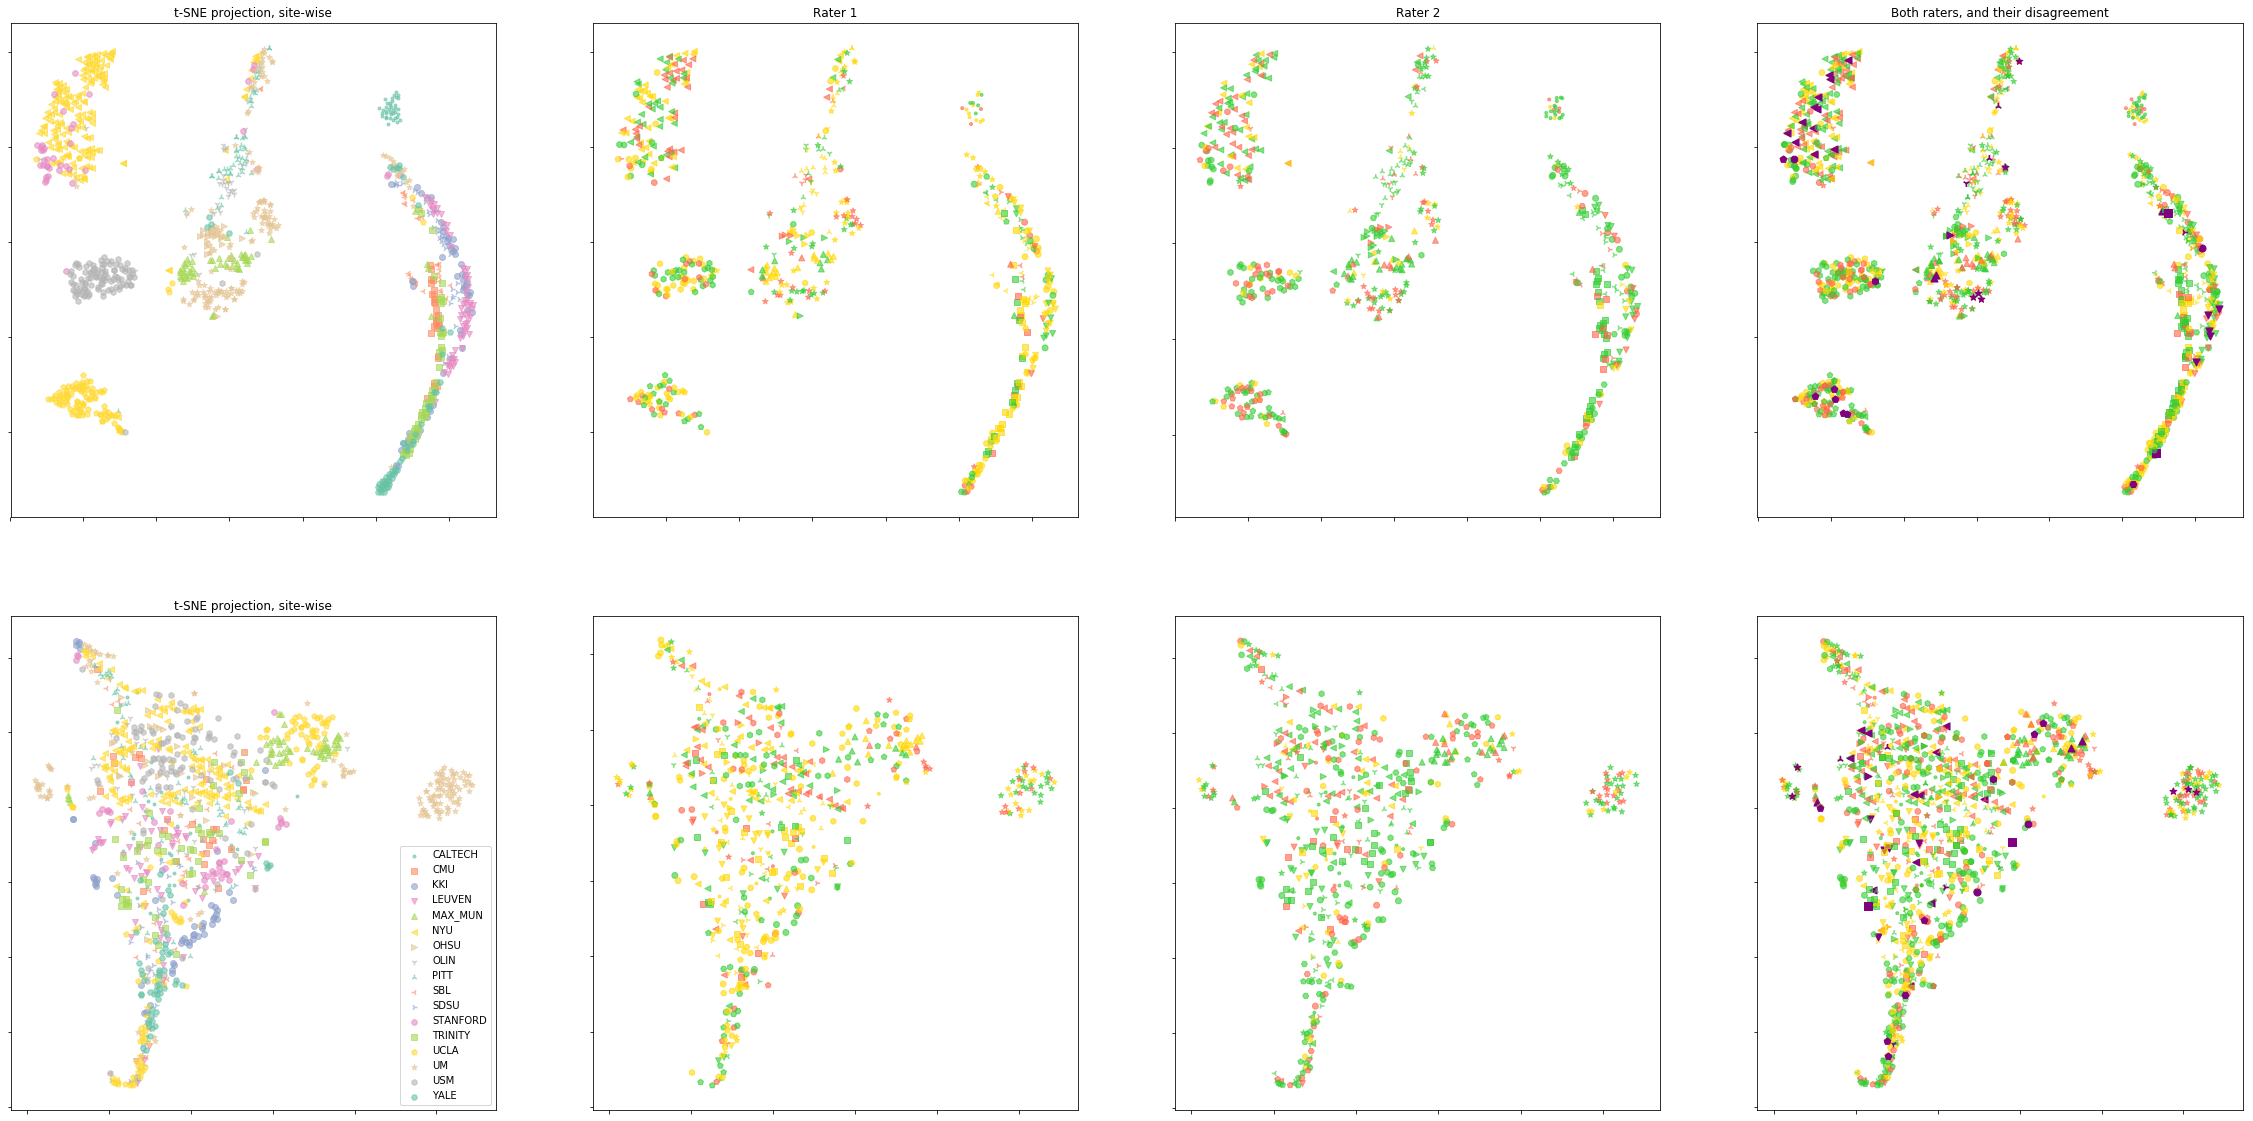

In [29]:
keep = np.array(keep)[~estimator.named_steps['ft_noise'].mask_]

x_abide_nosites = x_abide[keep]

tsne = TSNE(n_components=2, init='random', n_iter=5000, random_state=0)
Y = tsne.fit_transform(x_abide_nosites.values)

# Names of features that can be normalized
coi = list(set(coi).intersection(keep.tolist()))

x_abide_nosites_std = x_abide_nosites.copy()
for s in sites:
    site_idx = y_abide.site.str.contains(s)
    data = x_abide_nosites_std._get_numeric_data()
    site_mean = x_abide_nosites_std.loc[site_idx, coi].mean(0)
    site_sigma = mad(x_abide_nosites_std.loc[site_idx, coi].values, axis=0)
    x_abide_nosites_std.loc[site_idx, coi] -= site_mean
    x_abide_nosites_std.loc[site_idx, coi] /= site_sigma

Y_std = TSNE(n_components=2, init='random', n_iter=5000, random_state=0).fit_transform(x_abide_nosites_std.values)

fig = plt.gcf()
fig.set_size_inches(40, 20)

## Plot general t-SNE
plt.subplot(2, 4, 1)
legends = []
for s, c, m in zip(sites, colors, markers):
    legends.append(
        plt.scatter(Y[y_abide.site == s, 0], Y[y_abide.site == s, 1], c=c, marker=m, alpha=.6)
    )

plt.title("t-SNE projection, site-wise")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())

## Plot rater 1
plt.subplot(2, 4, 2)
y_rater1 = y_abide[~y_abide.rater_1.isnull()]
Y_r1 = Y[~y_abide.rater_1.isnull(), :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values])
legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)

plt.title("Rater 1")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())

## Plot rater 2
plt.subplot(2, 4, 3)

y_rater2 = y_abide[~y_abide.rater_2.isnull()]
Y_r2 = Y[~y_abide.rater_2.isnull(), :]

# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values])

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    
plt.title("Rater 2")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())


## Plot agreement
plt.subplot(2, 4, 4)
y_agree = y_abide[y_abide.rater_1 == y_abide.rater_2]
Y_a = Y[y_abide.rater_1 == y_abide.rater_2, :]

idx_dis = (y_abide.rater_1 != y_abide.rater_2) & (~y_abide.rater_1.isnull() & ~y_abide.rater_2.isnull())
y_disagree = y_abide[idx_dis]
Y_b = Y[idx_dis, :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values], alpha=.6)
# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values], alpha=.6)
# plt.scatter(Y_a[:, 0], Y_a[:, 1], c=[cmap[str(v)] for v in y_agree.rater_2.values], alpha=.6)
# plt.scatter(Y_b[:, 0], Y_b[:, 1], c='darkgray')

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_a[y_agree.site == s, 0], Y_a[y_agree.site == s, 1],
                c=[cmap[str(v)] for v in y_agree.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_b[y_disagree.site == s, 0], Y_b[y_disagree.site == s, 1], marker=m, c='purple', s=50)
    
    

plt.title("Both raters, and their disagreement")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())




## Plot general t-SNE
plt.subplot(2, 4, 5)
legends = []
for s, c, m in zip(sites, colors, markers):
    legends.append(
        plt.scatter(Y_std[y_abide.site == s, 0], Y_std[y_abide.site == s, 1], c=c, marker=m, alpha=.6)
    )

plt.title("t-SNE projection, site-wise")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())
plt.legend(legends, sites)

## Plot rater 1
plt.subplot(2, 4, 6)
y_rater1 = y_abide[~y_abide.rater_1.isnull()]
Y_r1 = Y_std[~y_abide.rater_1.isnull(), :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values])
legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)

plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())

## Plot rater 2
plt.subplot(2, 4, 7)

y_rater2 = y_abide[~y_abide.rater_2.isnull()]
Y_r2 = Y_std[~y_abide.rater_2.isnull(), :]

# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values])

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())


## Plot agreement
plt.subplot(2, 4, 8)
y_agree = y_abide[y_abide.rater_1 == y_abide.rater_2]
Y_a = Y_std[y_abide.rater_1 == y_abide.rater_2, :]

idx_dis = (y_abide.rater_1 != y_abide.rater_2) & (~y_abide.rater_1.isnull() & ~y_abide.rater_2.isnull())
y_disagree = y_abide[idx_dis]
Y_b = Y_std[idx_dis, :]

# plt.scatter(Y_r1[:, 0], Y_r1[:, 1], c=[cmap[str(v)] for v in y_rater1.rater_1.values], alpha=.6)
# plt.scatter(Y_r2[:, 0], Y_r2[:, 1], c=[cmap[str(v)] for v in y_rater2.rater_2.values], alpha=.6)
# plt.scatter(Y_a[:, 0], Y_a[:, 1], c=[cmap[str(v)] for v in y_agree.rater_2.values], alpha=.6)
# plt.scatter(Y_b[:, 0], Y_b[:, 1], c='darkgray')

legends = []
filtsites = []
for s, m in zip(sites, markers):
    legends.append(
        plt.scatter(Y_r1[y_rater1.site == s, 0], Y_r1[y_rater1.site == s, 1],
                    c=[cmap[str(v)] for v in y_rater1.rater_1.values], marker=m, alpha=.6)
    )
    filtsites.append(s)
    plt.scatter(Y_r2[y_rater2.site == s, 0], Y_r2[y_rater2.site == s, 1],
                c=[cmap[str(v)] for v in y_rater2.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_a[y_agree.site == s, 0], Y_a[y_agree.site == s, 1],
                c=[cmap[str(v)] for v in y_agree.rater_2.values], marker=m, alpha=.6)
    plt.scatter(Y_b[y_disagree.site == s, 0], Y_b[y_disagree.site == s, 1], marker=m, c='purple', s=50)
    
    plt.gca().xaxis.set_major_formatter(NullFormatter())
    plt.gca().yaxis.set_major_formatter(NullFormatter())

plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())


plt.savefig('MRIQC-abide-tsne-preproc.pdf', dpi=300, bbox_inches='tight')

In [24]:
estimator = loadpkl(CSV_HOME / '..' / 'mclf_run-20170724-191452_mod-rfc_ver-0.9.7-rc8_class-2_cv-loso_data-all_estimator.pklz')
keep = np.array(estimator.named_steps['sel_cols'].columns)[estimator.named_steps['ft_sites'].mask_]
discard = np.array(estimator.named_steps['sel_cols'].columns)[~estimator.named_steps['ft_sites'].mask_]

print(len(discard))

print('keep: %s' % ','.join(keep))
print('discard: %s' % ','.join(discard))

15
keep: cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,qi_1,qi_2,rpve_csf,rpve_gm,rpve_wm,snr_csf,snr_gm,snr_total,snr_wm,snrd_csf,snrd_gm,snrd_total,snrd_wm,summary_bg_k,summary_bg_stdv,summary_csf_k,summary_csf_mad,summary_csf_mean,summary_csf_median,summary_csf_p05,summary_csf_p95,summary_csf_stdv,summary_gm_k,summary_gm_mad,summary_gm_mean,summary_gm_median,summary_gm_n,summary_gm_p05,summary_gm_p95,summary_gm_stdv,summary_wm_k,summary_wm_mad,summary_wm_mean,summary_wm_median,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm
discard: icvs_wm,inu_med,inu_range,size_y,spacing_y,summary_bg_mad,summary_bg_mean,summary_bg_median,summary_bg_n,summary_bg_p05,summary_bg_p95,summary_csf_n,summary_wm_n,wm2max,site


In [13]:
from mriqc.viz import misc as mviz
from mriqc.classifier.sklearn import preprocessing as mcsp

# Names of all features
features =[
    'cjv', 'cnr', 'efc', 'fber',
    'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z',
    'icvs_csf', 'icvs_gm', 'icvs_wm',
    'inu_med', 'inu_range', 
    'qi_1', 'qi_2',
    'rpve_csf', 'rpve_gm', 'rpve_wm',
    'size_x', 'size_y', 'size_z',
    'snr_csf', 'snr_gm', 'snr_total', 'snr_wm',
    'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm',
    'spacing_x', 'spacing_y', 'spacing_z',
    'summary_bg_k', 'summary_bg_mad', 'summary_bg_mean', 'summary_bg_median', 'summary_bg_n', 'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv',
    'summary_csf_k', 'summary_csf_mad', 'summary_csf_mean', 'summary_csf_median', 'summary_csf_n', 'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv',
    'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean', 'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95', 'summary_gm_stdv',
    'summary_wm_k', 'summary_wm_mad', 'summary_wm_mean', 'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm_p95', 'summary_wm_stdv',
    'tpm_overlap_csf', 'tpm_overlap_gm', 'tpm_overlap_wm',
    'wm2max'
]

# Plot batches
fig = mviz.plot_batches(x_abide, cols=list(reversed(coi)))

# Apply new site-wise scaler
# scaler = mcsp.BatchRobustScaler(by='site', columns=coi)
# scaled = scaler.fit_transform(x_abide)
fig = mviz.plot_batches(x_abide_std, cols=coi, site_labels='right')

KeyError: 'database'

In [ ]:
idx_sites = y_abide.site.str.contains('PITT') & y_abide.site.str.contains('USM')

y_samesites = y_abide[~idx_sites]
x_samesites = x_abide[~idx_sites]

tsne = TSNE(n_components=2, init='random', random_state=0)
Y_sites = tsne.fit_transform(x_samesites.values)


legends = []
filtsites = []
for s, c, m in zip(sites, colors, markers):
    if s in ['PITT', 'USM']:
        continue
    legends.append(
        plt.scatter(Y_sites[y_samesites.site == s, 0], Y_sites[y_samesites.site == s, 1], c=c, marker=m, alpha=0.6)
    )
    filtsites.append(s)
    
plt.title("t-SNE")
plt.gca().xaxis.set_major_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(NullFormatter())
plt.legend(legends, filtsites)